In [1]:
%%capture
!pyenv exec pip install -r requirements.txt

## Importando libs

In [2]:
import os
import re
import torch
import seaborn as sns
from d2l import torch as d2l
import matplotlib.pyplot as plt

## Baixando e extraindo os dados

In [3]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



## Pré-processamento

In [4]:
def preprocess_nmt(text):
    """
    Preprocessa o texto para um modelo de tradução neural, removendo caracteres especiais e 
    adicionando espaços antes de pontuações onde necessário.
    """
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    
    text = re.sub(r'(?<!\s)([,.!?])', r' \1', text)
    
    return text

text = preprocess_nmt(raw_text)
print(text[:80])


go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## Tokenização

In [5]:
def tokenize_nmt(text, num_examples=None):
    """
    Tokeniza um texto de tradução para um modelo NMT, dividindo cada linha em tokens de fonte e destino.
    
    Args:
        text (str): O texto de entrada contendo sentenças de fonte e destino separadas por tabulações.
        num_examples (int, opcional): Número máximo de exemplos a serem processados. Se None, processa todos.

    Returns:
        tuple: Listas de tokens de sentenças de origem e destino.
    """
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples is not None and i >= num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split())
            target.append(parts[1].split())
    
    return source, target

source, target = tokenize_nmt(text)
print(source[:6], target[:6])


[['go', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?'], ['wow', '!']] [['va', '!'], ['salut', '!'], ['cours', '!'], ['courez', '!'], ['qui', '?'], ['ça', 'alors', '!']]


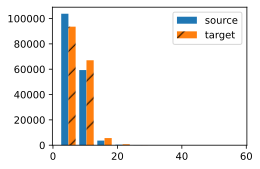

In [6]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right')

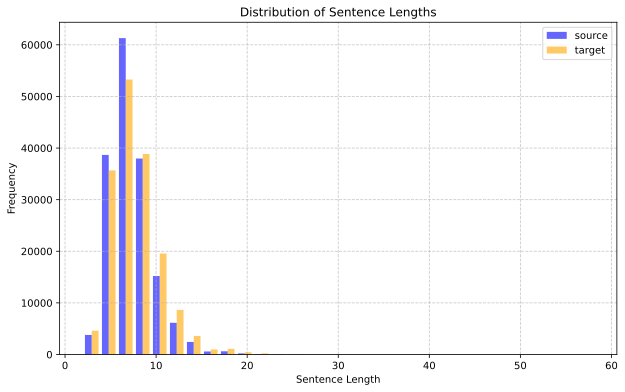

In [7]:
def plot_histograms(source, target):
    plt.figure(figsize=(10, 6))
    plt.hist([ [len(l) for l in source], [len(l) for l in target] ],
             bins=30, alpha=0.6, label=['source', 'target'], color=['blue', 'orange'])
    plt.title('Distribution of Sentence Lengths')
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')
    plt.show()

plot_histograms(source, target)


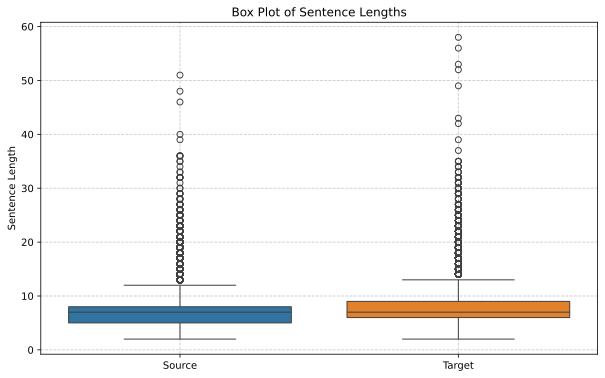

In [8]:
def plot_boxplots(source, target):
    plt.figure(figsize=(10, 6))
    data = {'Source': [len(l) for l in source], 'Target': [len(l) for l in target]}
    sns.boxplot(data=data)
    plt.title('Box Plot of Sentence Lengths')
    plt.ylabel('Sentence Length')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_boxplots(source, target)

## Vocabulário

In [9]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

## Carregando os dados

In [10]:
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

In [11]:
def build_array_nmt(lines, vocab, num_steps):
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

## Gran-finale

In [12]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [19]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)

def visualize_batch(train_iter, src_vocab, tgt_vocab):
    for X, X_valid_len, Y, Y_valid_len in train_iter:
        X_words = [[src_vocab.to_tokens(index) for index in seq] for seq in X.tolist()]
        Y_words = [[tgt_vocab.to_tokens(index) for index in seq] for seq in Y.tolist()]
        
        print("Fonte (X):")
        for i, (seq, valid_len) in enumerate(zip(X_words, X_valid_len.tolist())):
            print(f"  Sequência {i+1}: {' '.join(seq[:valid_len])} (comprimento válido: {valid_len})")
        
        print("\nDestino (Y):")
        for i, (seq, valid_len) in enumerate(zip(Y_words, Y_valid_len.tolist())):
            print(f"  Sequência {i+1}: {' '.join(seq[:valid_len])} (comprimento válido: {valid_len})")
        
        break

visualize_batch(train_iter, src_vocab, tgt_vocab)

Fonte (X):
  Sequência 1: go get it . <eos> (comprimento válido: 5)
  Sequência 2: show me . <eos> (comprimento válido: 4)

Destino (Y):
  Sequência 1: allez le chercher ! <eos> (comprimento válido: 5)
  Sequência 2: <unk> ! <eos> (comprimento válido: 3)
